# State-by-state 2pp voting trends
- Gaussian Random Walk model
- but no house-effects model
- and not constrained back to any national model

__NOTE:__
* Please run the *_data_capture.ipynb* notebook before running this notebook.

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache

# analytic imports
import pandas as pd
import matplotlib.pyplot as plt

# PyMC imports
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]
import pytensor  # type: ignore[import-untyped]
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
## Plotting initialisation
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + '/bayesian-state-2pp-aggregation/')
    plotting.clear_chart_dir()


set_up_plotting()

### Check operating environment

In [5]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.2.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pymc      : 5.22.0
arviz     : 0.21.0
pytensor  : 2.30.3
pandas    : 2.2.3
matplotlib: 3.10.1

Watermark: 2.5.0



## Get data

In [6]:
ORDERED_STATES = ["NSW", "VIC", "QLD", "WA", "SA", "TAS", "NT", "ACT"]

### State poll results

In [7]:
def get_poll_data() -> dict[str, pd.DataFrame]:
    """Retrieve raw data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved

In [8]:
def extract_state_polls(
    raw: dict[str, pd.DataFrame] | None = None,
    minimum: int = 10,  # minimum required number of polls
    column: str = "2pp vote ALP",
) -> tuple[dict[str, pd.Series], dict[str, pd.DataFrame]]:
    """Retrieve the 2pp state polls.
    Returns a tuple:
    1: dict state-keys and poll-values, and
    2: dict of state-keys and polling-brand-values (used in plotting).
    """

    if raw is None:
        raw = get_poll_data()

    cooked_data = {}
    brands = {}
    for state in [VOTING_INTENTION] + ORDERED_STATES:
        if state not in raw:
            print(f"Missing {state} data")
            continue
        data = raw[state].copy()  # don't modify the raw data
        data.index = pd.PeriodIndex(data[MIDDLE_DATE], freq="M")
        series = data.sort_index(ascending=True)[column]
        brand = data[[MIDDLE_DATE, "Brand", column]]

        if len(series) < minimum:
            print(f"Not enough data for {state}: n={len(series)}")
            continue

        name = state if state in ORDERED_STATES else "Australia"
        cooked_data[name] = series
        brands[name] = brand

    return cooked_data, brands


POLLS, BRANDS = extract_state_polls()
print(POLLS.keys())

Not enough data for TAS: n=5
Not enough data for NT: n=2
Missing ACT data
dict_keys(['Australia', 'NSW', 'VIC', 'QLD', 'WA', 'SA'])


### Previous election - state and national starting points

In [9]:
previous_election = {
    # 2pp vote ALP
    "Australia": 52.13,
    "NSW": 51.42,
    "VIC": 54.83,
    "QLD": 45.95,
    "WA": 55,
    "SA": 53.97,
    "TAS": 54.33,
    "ACT": 66.95,
    "NT": 55.54,
}

## Data preparation

### National Data

In [10]:
def get_timeline() -> tuple[pd.Period, pd.Period]:
    """Get the start and end of the timeline for the national data."""

    election_2022 = pd.Period("2022-05-21", freq="M")
    national = retrieve()
    national_dates = pd.PeriodIndex(
        national[VOTING_INTENTION][MIDDLE_DATE].dropna(), freq="M"
    )

    # - time frames
    first_month = election_2022
    assert first_month <= national_dates.min()
    last_month = national_dates.max()
    return first_month, last_month


FIRST_MONTH, LAST_MONTH = get_timeline()
N_MONTHS = (LAST_MONTH - FIRST_MONTH).n + 1
assert N_MONTHS > 1

### State data

In [11]:
def build_states_data() -> dict[str, dict[str, Any]]:
    """Build the state data for the model."""

    states_data: dict[str, dict[str, Any]] = {}
    for state, y in POLLS.items():
        # sanity checks
        assert isinstance(y, pd.Series)
        assert isinstance(y.index, pd.PeriodIndex)
        assert y.index.freq == "ME"
        assert y.index.min() >= FIRST_MONTH
        assert y.index.max() <= LAST_MONTH
        assert y.index.is_monotonic_increasing

        # - package up state data
        state_data: dict[str, Any] = {}
        state_data["y"] = y.to_numpy()
        state_data["n_polls"] = len(y)
        state_data["start"] = previous_election[state]
        state_data["poll_month"] = [(x - FIRST_MONTH).n for x in y.index]
        state_data["brand"] = BRANDS[state]
        states_data[state] = state_data

    return states_data


STATES_DATA = build_states_data()
print(STATES_DATA.keys())

dict_keys(['Australia', 'NSW', 'VIC', 'QLD', 'WA', 'SA'])


## Build a model to estimate state based voting intention

### Sampler settings

In [12]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]
    plot_trace: NotRequired[bool]


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 2_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
        "plot_trace": False,
    }

    return settings

### Model build

In [13]:
SIGMA_POLLS = 2  # 95% of polls are within +/-4ppt of the population voting intention
SIGMA_MONTH = 1.5  # 95% of the voting intention is within +/-3ppt of the previous month


def build_model(
    for_state: str,
) -> pm.Model:
    """Builds a simple PyMC model for a monthly Gaussian Random Walk.
    NOTE: model is working with whole percentage points, not fractions."""

    # -- state specifiv data
    assert for_state in STATES_DATA
    params = STATES_DATA[for_state]
    start = params["start"]
    print(for_state)

    # -- model
    n_polls = params["n_polls"]
    coords = {
        "months": range(N_MONTHS),
        "polls": range(n_polls),
    }

    with (model := pm.Model(coords=coords)):
        # -- temporal model
        vi = pm.GaussianRandomWalk(
            "vi",
            mu=0,
            # anchor firmly to the previous election result
            init_dist=pm.Normal.dist(mu=start, sigma=0.0001),
            sigma=SIGMA_MONTH,
            dims="months",
        )

        # -- likelihood / observational model
        _observed = pm.Normal(
            "observed",
            mu=vi[params["poll_month"]],  # pylint: disable=unsubscriptable-object
            sigma=SIGMA_POLLS,
            observed=params["y"],
            dims="polls",
        )

    return model


# quick check
_test = build_model("Australia")

Australia


### Run the model for each State

In [14]:
def run_the_model(make_map: bool = False) -> dict[str, tuple]:
    """Run the model for each state and return the results."""

    results: dict[str, tuple] = {}
    for state in STATES_DATA:
        a_model = build_model(state)

        if make_map:
            bayes_tools.generate_model_map(
                a_model, f"dirichlet_state_vi_{state}", MODEL_DIR, display_images=True
            )

        with a_model:
            sampling = sampler_settings()
            idata, glitches = bayes_tools.draw_samples(a_model, **sampling)
            results[state] = idata, glitches

    return results


model_results = run_the_model()

Australia


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 7076.0
Divergences: 0
NSW


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 5555.0
Divergences: 0
VIC


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 5435.0
Divergences: 0
QLD


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 5445.0
Divergences: 0
WA


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 3811.0
Divergences: 0
SA


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Max r_hat: 1.0
Min ess: 3852.0
Divergences: 0


## Charts

In [15]:
@cache
def _get_var(state: str, var_name: str) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    idata, _glitches = model_results[state]
    inf_data = az.extract(idata)
    return inf_data.transpose("sample", ...).to_dataframe()[var_name]

In [16]:
# useful reminder of the index names
for state_ in model_results:
    data_ = _get_var(state_, "vi")
    print(state_, data_.index.names)

Australia ['months', 'chain', 'draw']
NSW ['months', 'chain', 'draw']
VIC ['months', 'chain', 'draw']
QLD ['months', 'chain', 'draw']
WA ['months', 'chain', 'draw']
SA ['months', 'chain', 'draw']


### Raw plots

In [17]:
def plot_monthly(
    ax: plt.Axes,
    month_data: pd.DataFrame,
) -> None:
    """Plot the monthly data for a state."""

    # set-up
    percents = [2.5, 25, 47.5]
    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]
    start_month: pd.Period = pd.Period(FIRST_MONTH, freq="M")
    color = plt.get_cmap("Reds")

    for i, pct in enumerate(percents):
        quants = pct, 100 - pct
        label = f"{quants[1] - quants[0]:0.0f}% HDI"

        x, y1, y2 = [], [], []
        for month in month_data.columns:
            period = str(month + start_month)[2:]  # type: ignore[operator]
            vi = month_data[month]
            lower, upper = [vi.quantile(q=q / 100.0) for q in quants]
            x.append(period)
            y1.append(lower)
            y2.append(upper)

        intensity = intensity_fracs[i]
        ax.fill_between(
            x=x,  # type: ignore[arg-type]
            y1=y1,
            y2=y2,
            color=color(intensity),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )


def plot_last_election(
    ax: plt.Axes,
    state: str,
) -> None:
    """Plot the last election result for a state."""

    ax.axhline(
        y=previous_election[state],
        color="black",
        linestyle="--",
        linewidth=0.75,
        alpha=0.5,
        label="Last election result",
        zorder=1,
    )


def plot_polls(
    ax: plt.Axes,
    state: str,
) -> None:
    """Plot the polls for a state."""
    brand_data = BRANDS[state].copy().reset_index(drop=True)
    brand_data["adj_date"] = [
        str(x)[2:] for x in pd.PeriodIndex(brand_data[MIDDLE_DATE], freq="M")
    ]
    for i, brand in enumerate(brand_data["Brand"].unique()):
        brand_set = brand_data[brand_data["Brand"] == brand].index
        plot_set = brand_data.loc[brand_set]
        ax.scatter(
            plot_set["adj_date"],
            plot_set["2pp vote ALP"],
            marker=plotting.MARKERS[i],
            c="#444444",
            s=20,
            label=brand,
            zorder=100,
        )


def plot_end_point(
    ax: plt.Axes,
    medians: pd.Series,
) -> None:
    """Plot the end point of the median series."""
    ax.text(
        # name the median endpoint
        x=medians.index[-1],
        y=medians.iloc[-1],
        s=f" {medians.iloc[-1]:0.1f}",
        color="#333333",
        fontsize="xx-small",
        ha="left",
        va="center",
    )


def plot_state_timeseries(
    state: str, vi_data: pd.DataFrame, glitches: str
) -> tuple[float, pd.Series]:
    """Plot the state timeseries for the voting intention data.
    Return the net movement from election to latest median,
    and the median series in a tuple."""

    # data preparation
    month_data = pd.DataFrame(vi_data.unstack(level="months"))
    month_data.columns = month_data.columns.droplevel().astype(int)
    medians: pd.Series = month_data.median()

    # plot
    _fig, ax = plt.subplots()
    plot_monthly(ax, month_data)
    plot_polls(ax, state)
    plot_last_election(ax, state)
    plot_end_point(ax, medians)

    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    poll_count = STATES_DATA[state]["n_polls"]
    header = (
        f"Assumed month on month standard deviation = {SIGMA_MONTH} ppt. "
        + f"Assumed polling standard deviation from actual = {SIGMA_POLLS} ppt. "
    )
    plotting.finalise_plot(
        ax,
        title=f"Bayesian Aggregation: {state} ALP 2pp Voting Intention (Monthly)",
        ylabel="Per cent 2pp votes",
        xlabel="Year-Month",
        legend={"loc": "best", "fontsize": "xx-small", "ncol": 3},
        lfooter="Data sourced from Wikipedia. House effects ignored. GRW. "
        + f"Based on {poll_count} poll{'s' if poll_count > 1 else ''}. "
        + "2pp=Pollster Estimates. ",
        rfooter="marktheballot.blogspot.com",
        rheader=glitches if glitches else header,
        y50=True,
        show=True,
    )

    return medians.iloc[-1] - previous_election[state], medians

In [18]:
def plot_changes(movements: dict[str, float]) -> None:
    """Plot the changes in the voting intention data
    since the 2022 Election."""

    series = pd.Series(movements)
    _fig, ax = plt.subplots()
    ax.bar(
        x=series.index,
        height=series,
        color="red",
        alpha=0.67,
    )
    # labels = ax.get_xticklabels()
    # ax.set_xticklabels(labels, rotation=0)
    inc = abs(series.min() - series.max()) * 0.01
    for state, c in movements.items():
        ax.text(
            x=state,  # type: ignore[arg-type]
            y=inc if c < 0 else -inc,
            s=f"{c:.1f}",
            va="bottom" if c < 0 else "top",
            ha="center",
            color="#444444",
            fontsize="small",
        )

    plotting.finalise_plot(
        ax,
        title="Change in ALP 2pp Voting Intention since the 2022 Election",
        xlabel=None,
        ylabel="Percentage points",
        lfooter="Data sourced from Wikipedia. House effects ignored. Monthly GRW. "
        + "2pp=Pollster Estimates. ",
        rfooter="marktheballot.blogspot.com",
        y0=True,
        show=True,
    )

In [19]:
def plot_medians(medians: dict[str, pd.Series]) -> None:
    """Plot the index medians for the voting intention data."""

    colors = {
        "Australia": "gray",
        "NSW": "deepskyblue",
        "VIC": "navy",
        "QLD": "#c32148",  # a lighter maroon
        "SA": "red",
        "WA": "gold",
        "TAS": "seagreen",  # bottle green is too dark #006A4E
        "NT": "#CC7722",  # ochre
        "ACT": "blue",
    }
    ls = ["-", "--", "-.", ":"] * 3

    _fig, ax = plt.subplots()
    for i, (state, series) in enumerate(medians.items()):
        series.index = pd.PeriodIndex([FIRST_MONTH + x for x in series.index], freq="M")
        ax.plot(
            series.index.astype(str),
            series,
            label=state,
            c=colors[state],
            lw=3,
            ls=ls[i],
        )
    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    plotting.finalise_plot(
        ax,
        title="Bayesian Aggregation: ALP 2pp Voting Intention (Monthly)",
        ylabel="Per cent 2pp votes",
        xlabel="Year-Month",
        legend={"loc": "upper right", "fontsize": "small", "ncol": 3},
        lfooter="Data sourced from Wikipedia. House effects ignored. "
        + "2pp=Pollster Estimates. GRW Bayesian Medians. ",
        rfooter="marktheballot.blogspot.com",
        y50=True,
        show=True,
    )

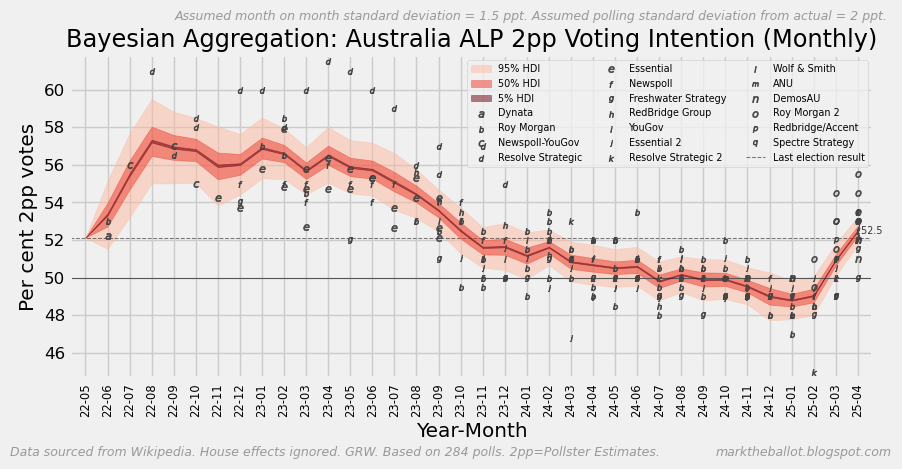

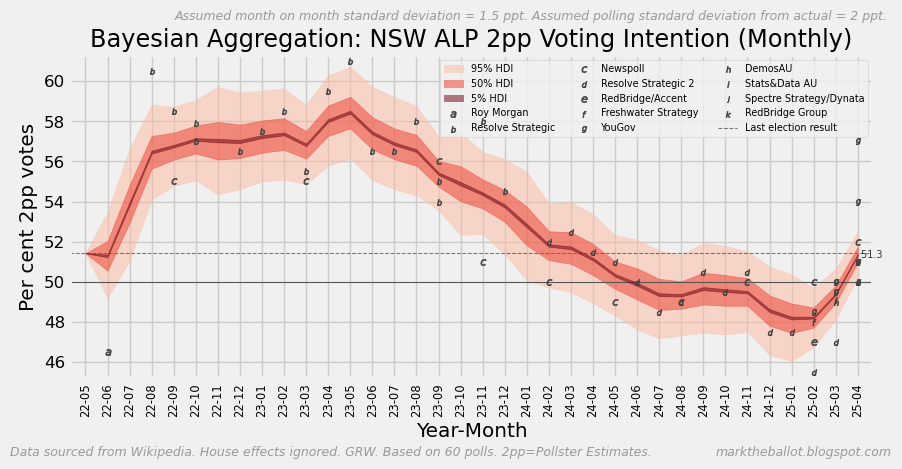

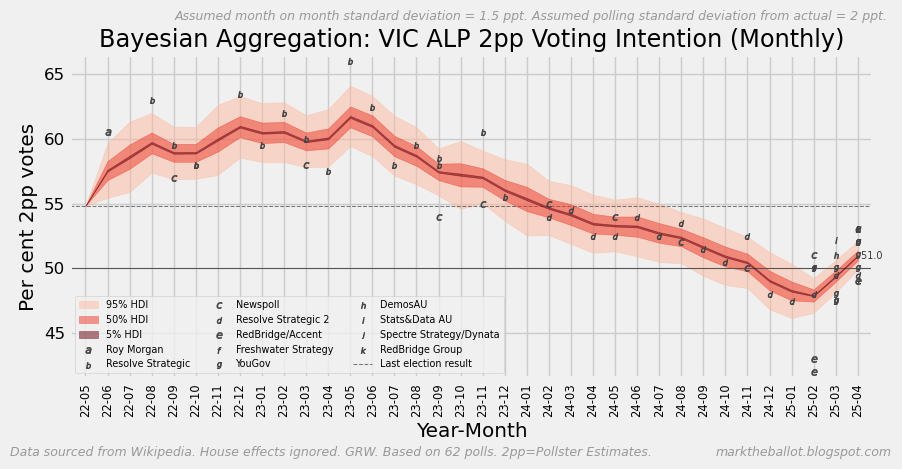

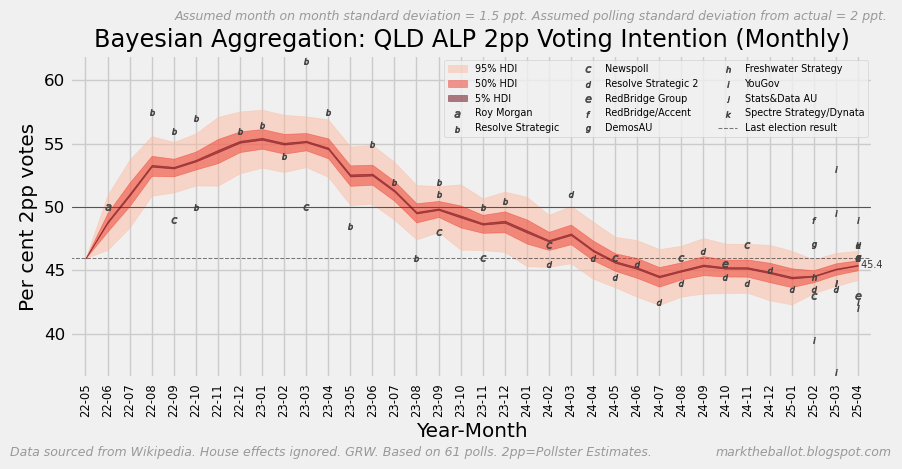

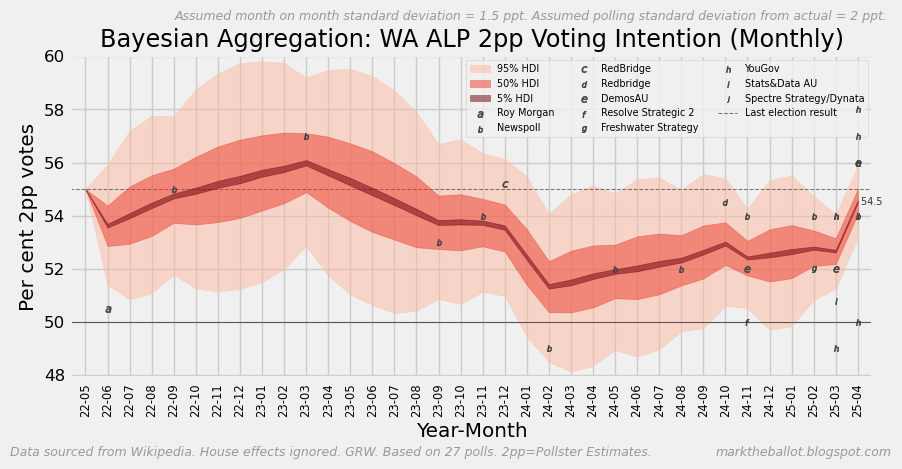

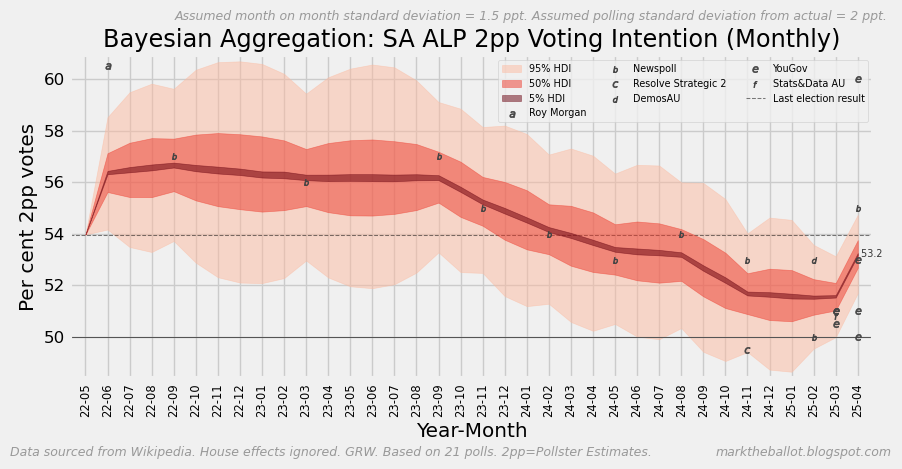

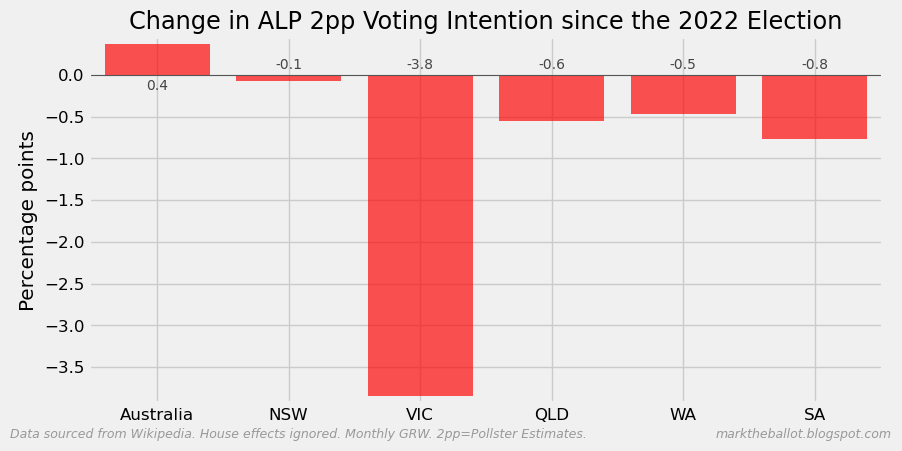

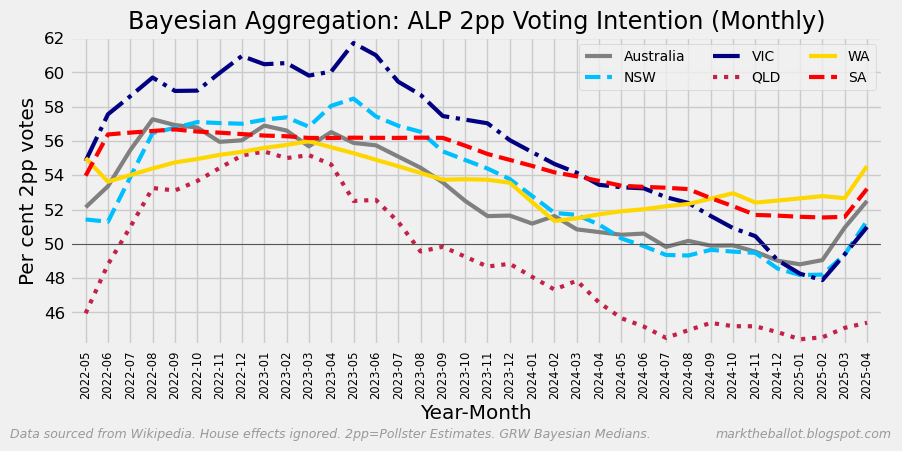

In [20]:
def state_plots() -> None:
    """Plot the state level results."""

    movements = {}
    medians = {}
    for state in STATES_DATA:
        if state not in model_results:
            continue
        _, glitches = model_results[state]
        vi_data: pd.DataFrame = pd.DataFrame(_get_var(state, "vi"))

        movements[state], medians[state] = plot_state_timeseries(
            state, vi_data, glitches
        )
    plot_changes(movements)
    plot_medians(medians)


state_plots()

## Finished

In [21]:
print("Finished")

Finished
